In [1]:
#%matplotlib inline
import numpy as np
import os
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from PIL import Image
import matplotlib.pyplot as plt

from nuscenes.nuscenes import NuScenes
import nuscenes.lidarseg
from nuscenes.utils.data_classes import LidarPointCloud, RadarPointCloud, Box

import utils_obj_det
from utils_obj_det import get_radar_in_img, vis_obj_det_speed, cluster_in_img_sweep#, vis_obj_det_speed_sweeps
from utils_obj_det import process_and_cluster, top_down_bb, cluster_sample, top_down_bb_sweep, draw_bb_points_in_image
from utils_obj_det import get_radar_in_img_sweeps, get_IoU, plot_3d, plot_2d, all_car_pos, plot
import utils_data_viewer
from utils_data_viewer import radar_from_file, fuse_radars_in_ego, visualize_radar_in_img, custom_draw_geometry, cam_vis
from utils_data_viewer import project_custom_pcd_in_img, project_bb_in_img, visualize_radar_in_img_sweeps, interactive_vis_radar_sweeps
from utils_data_viewer import get_scene_radars_sweeps, fuse_radars_in_ego_sweeps, project_points_in_img

from Detection import Detection
from Pose import Pose


import time
from scipy.spatial.transform import Rotation
from pyquaternion import Quaternion

import cv2
import open3d as o3d


nusc = NuScenes(version='v1.0-mini', dataroot='/data/sets/nuscenes', verbose=True)
utils_obj_det.nusc = nusc
utils_data_viewer.nusc = nusc
#nusc.list_scenes()
sc_id = 4

scene = nusc.scene[sc_id]
log = nusc.get('log', scene['log_token'])
map = nusc.get('map', log['map_token'])
map_file = os.path.join(nusc.dataroot, map['filename'])

first_sample = nusc.get('sample', scene['first_sample_token'])
last_sample = nusc.get('sample', scene['last_sample_token'])
sample = first_sample

	
COCO_INSTANCE_CATEGORY_NAMES = ['__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']



Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.543 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


# Kalman Filter
The following function iterates through all available camera frames and, using the timestamps finds the temporally closest lidar and radar scans. At the end of the loop, the lidar and front radar get updated when progressing to the next frame. The remaining radars get updated at the beginning of the loop. This rendering loop uses the pre-trained faster RCNN model to find objects in the 2D camera frame, the outputs are 2D bounding boxes, the confidence values, and the class labels. All further tracking associates the objects using the 2D bounding box. To temporally track objects, the IoU of bounding boxes between frame `N` and frame `N-1` is used to find the corresponding object. The classes **Detection** and **Pose** were designed to identify each object. **Detection** objects have a list of previous **Pose** objects, as well as a current **Pose** object. If a temporal association was created between bounding boxes in the current and previous frame, the new **Pose** gets added to the **Detection** object. 

To detect objects in 3D space, Euclidean clustering is performed on a single lidar pointcloud. The results are processed, filtered, and added to the **Pose** variable of the **Detection** object that was created for each detected bounding box. The **Detection** class also includes a *Kalman Filter* for each object. *Kalman Filter* is initialized once two 3D measurements exist for the **Detection** object. The *Kalman Filter* is then applied in each frame to update the 3D position of the **Detection** object. Should no 3D measurement exist for this frame, for example, because the Euclidean clustering failed, only the prediction step of the *Kalman Filter* is executed to extrapolate the potential new position of the object. 

The position data is stored in the global coordinate frame. This means it has to be transformed into the lidar coordinate frame for projection into the image and back to the global coordinate system afterward. The tracking data is visualized once in the chosen camera image and in the BEV map. In the camera image, 3D measurements from the clustering are shown as orange dots. The *Kalman Filtering* result is visualized as a blue dot if 3D measurements were available and as a green dot if only the prediction was performed. The BEV map includes the ground truth as well. By hovering the mouse over any object in the image following additional information is shown if the object was detected by the 2D detection model: The bounding box, class, velocity estimated from radar, as well as a red dot showing the ground truth position.

In [2]:
mouse_x = -1
mouse_y = -1
def mouse_callback(event, x, y, flags, param):
    global mouse_x, mouse_y
    if event == cv2.EVENT_MOUSEMOVE:
        mouse_x = x
        mouse_y = y


def kf_tracking_3d(scene, cam_channel='CAM_FRONT', show_speed=True, radar_points=False, record=False, traj_only_on_hover=True, show_anns=False):
    """
    Runs a 3D Lidar detection algorithm that employs euclidean clustering and the kalman filter among other methods.
    :param scene: The nuScenes scene object
    :param cam_channel: A string that defines the camera channel that should be used.
    :param show_speed: When set to True the detected Radar speed will be visualized along with the 
        bounding box when the user hovers over an object with the mouse.
    :param radar_points: When set to True the detected Radar points of each object will be
        visualized inside the bounding box. If the user hovers over the object with the mouse.
    :param record: When set to True the rendered images of the main window and the
        BEV window will be saved in two separate video files.
    :param traj_only_on_hover: When set to True, the trajectory and velocity vector of the Detection object will only 
        be rendered if the user hovers over the corresponding object in the main window.
    :param show_anns: When set to True, ground truth positions for all detected objects are visualized as a white dot.
    :return: A list containing all Detection objects that were created for this scene.
    """
    global mouse_x, mouse_y
    first_sample = nusc.get('sample', scene['first_sample_token'])
    last_sample = nusc.get('sample', scene['last_sample_token'])
    sample = first_sample

    #Load Faster RCNN model, set it to evaluation mode and send it to GPU
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    model.eval()
    model.to('cuda')

    ##Create OpenCV Window and set mouse callback
    #Main Window
    winname = cam_channel
    window_width, window_height = 1600, 900
    cv2.namedWindow(winname, cv2.WINDOW_NORMAL)
    cv2.resizeWindow(winname, window_width, window_height)
    cv2.setMouseCallback(winname, mouse_callback)
    #BEV Window
    winname_bev = "BEV Trajectories"
    win_width_bev, win_height_bev = 900, 900
    cv2.namedWindow(winname_bev, cv2.WINDOW_NORMAL)
    cv2.resizeWindow(winname_bev, win_width_bev, win_height_bev)
    bev_center = np.array([win_width_bev/2, win_height_bev/2])
    ##

    #Confidence threshold, box and text size/thickness for FRCNN Detections
    threshold = 0.8
    rect_th=1
    text_size=0.9
    text_th=2

    if record:
        name = scene['name'] + "_KF2_" + cam_channel + ".avi"
        out = cv2.VideoWriter(name, cv2.VideoWriter_fourcc(*'DIVX'), 8, (window_width, window_height))
        b_name = scene['name'] + "_KF2_TRAJ.avi"
        b_out = cv2.VideoWriter(b_name, cv2.VideoWriter_fourcc(*'DIVX'), 8, (win_width_bev, win_height_bev))

    #Initialize radar_front from first sample, get all radars from scene and get their timestamps
    radar_front = nusc.get('sample_data', first_sample['data']['RADAR_FRONT'])
    radars = get_scene_radars_sweeps(first_sample)
    radars_time = [np.asarray([rad['timestamp'] for rad in rads]) for rads in radars]

    #Get List of all Lidars
    lidars = []
    lidar = nusc.get('sample_data', first_sample['data']['LIDAR_TOP'])
    while lidar['next'] != '':
        lidars.append(lidar)
        lidar = nusc.get('sample_data', lidar['next'])
    #np array of timestamps
    lidar_time = np.asarray([lidar['timestamp'] for lidar in lidars])
    lidar = nusc.get('sample_data', first_sample['data']['LIDAR_TOP'])

    cam = nusc.get('sample_data', first_sample['data'][cam_channel])

    
    #List of currently (per frame) tracked Detection objects, one for each bounding box
    tracking = []
    #List of all detections in the scene
    all_detections = []
    ###

    #Render Loop
    while True:
        #Increase lost tracking counter and push 'latest' detections to list for all Detections
        for det in tracking:
            det.next_frame()

        #BEV Image
        bev_img = np.zeros([win_height_bev, win_width_bev, 3], dtype=np.uint8)
        bev_img.fill(20)
        ##########################################
        ########################################## BEGIN 2D OBJECT DETECTION

        #Load Image
        cam_file = os.path.join(nusc.dataroot, cam['filename'])
        cam_img = cv2.imread(cam_file)

        #Change to RGB only for conversion to tensor, add dimension for model prediction
        cam_tensor = F.to_tensor(cv2.cvtColor(cam_img, cv2.COLOR_BGR2RGB)).unsqueeze(0).to('cuda')
        
        with torch.no_grad():
            pred = model(cam_tensor)
        
        #Match extracted labels to pre defined labels list
        pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].cpu().numpy())]

        #Create array of this frames bounding boxes
        bounding_boxes = pred[0]['boxes'].cpu().detach().numpy().astype(int) #(N,4)

        #Get Scores
        pred_score = list(pred[0]['scores'].cpu().detach().numpy())
        #Get indices of scores above threshold - All results are sorted with decreasing confidence
        cutoff_index = [pred_score.index(x) for x in pred_score if x>threshold]
        #Only continue if there are detections above confidence threshold
        if len(cutoff_index) > 0:
            #Set pred_t to last element in list, thus last index which has score above threshold
            cutoff_index = cutoff_index[-1]
            #Slice prediction box and labels to only contain values above threshold
            bounding_boxes = bounding_boxes[:cutoff_index+1]
            pred_class = pred_class[:cutoff_index+1]
            ########################################## END 2D OBJECT DETECTION
            ########################################## BEGIN Get Radar Data
            ###Create radar_set, which contains the radar scans that belong to this scan
            #Find radar scans that are temporally close to radar_front
            diffs = [np.asarray(rad_time - radar_front['timestamp']) for rad_time in radars_time]
            #Ensure that other radars are older than radar_front - This is not neccessary
            diffs = [np.where(dif > 0, dif, np.inf) for dif in diffs]
            diffs = np.abs(diffs)

            radar_front_left = radars[1][diffs[1].argmin()]
            radar_front_right = radars[2][diffs[2].argmin()]
            radar_back_left = radars[3][diffs[3].argmin()]
            radar_back_right = radars[4][diffs[4].argmin()]
            
            #This frames list of radars which lie temporally close
            radar_set = [radar_front, radar_front_left, radar_front_right, radar_back_left, radar_back_right]
            scan, fields = fuse_radars_in_ego_sweeps(radar_set) #18xN
            ###

            #Get velocities
            points, scan = get_radar_in_img_sweeps(cam, radar_set)

            ### Create list of radar measurements per detected object
            #Combined mask of all radar points in bbs - for visualization
            comb_mask = np.zeros(points.shape[1])
            
            #List of np arrays that contain the radar measurements for each bounding box, or np.nan if not measurement found
            radar_measurements = [] 
            for i in range(bounding_boxes.shape[0]):
                #Create mask for scan points that lie inside the bounding box
                xmin = bounding_boxes[i][0]
                ymin = bounding_boxes[i][1]
                xmax = bounding_boxes[i][2]
                ymax = bounding_boxes[i][3]
                mask = np.ones(points.shape[1])
                mask = np.logical_and(mask, points[0, :] >= xmin)
                mask = np.logical_and(mask, points[0, :] <= xmax)
                mask = np.logical_and(mask, points[1, :] >= ymin)
                mask = np.logical_and(mask, points[1, :] <= ymax)
                comb_mask = np.logical_or(comb_mask, mask)

                #Check if any radar points are inside bb 
                if np.any(mask) and show_speed:
                    #Further processing of detected radar measurements could be done here (norm, average, max, etc.)
                    #X and Y velocities (compensated) from points in bb
                    obj_v = scan[8:10, mask] #Compensated V - Raw V would be [6:8] 

                    #Append deepcopy to measurements list
                    radar_measurements.append(np.copy(obj_v))

                else: 
                    radar_measurements.append(np.nan)
            ###
            ########################################## END Get Radar Data
            ########################################## BEGIN Get LiDAR data and cluster the pcd
            #Ego position from lidar scan
            ego_pose = nusc.get("ego_pose", lidar['ego_pose_token'])
            ego_t = np.asarray(ego_pose['translation'])
            ego_r_quat = Quaternion(ego_pose['rotation'])

            ego_pos = np.asarray(ego_pose['translation'])
            #Bring ego pos into lidar axis order
            lidar_cs = nusc.get("calibrated_sensor", lidar['calibrated_sensor_token'])
            lidar_t = np.asarray(lidar_cs['translation'])
            lidar_r_quat = Quaternion(lidar_cs['rotation'])
            ego_pos = np.dot(lidar_r_quat.rotation_matrix.T, ego_pos.T).T

            #Load lidar scan
            lidar_file = nusc.get_sample_data_path(lidar['token'])
            scan = np.fromfile(lidar_file, dtype=np.float32).reshape(-1, 5) #x, y, z, intensity, Ring Index
            lidar_points = scan[:, :3] #Only x, y, z
            lidar_pcd = o3d.geometry.PointCloud()
            lidar_pcd.points = o3d.utility.Vector3dVector(lidar_points)

            ####Clustering
            #Create point cloud with cluster colors
            cluster_pcd, cluster_labels = process_and_cluster(lidar_pcd)

            #List of cluster points - Each array represents one cluster
            #cluster_labels is used to index the points to extract each cluster
            clusters = [np.array(cluster_pcd.points)[cluster_labels == i] for i in range(cluster_labels.max()+1)]
            
            ###Filter center points to those that lie in image
            #create list of pointclouds from points in cluster (Easy method to get its center)
            pcd_clusters = [o3d.geometry.PointCloud(o3d.utility.Vector3dVector(pts)) for pts in clusters]
            #Project center points of bbs into image
            cluster_center = np.array([cl.get_center() for cl in pcd_clusters]) #(N,3)
            cl_center_pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(cluster_center)) #Create pointcloud of center points (for easy projection)
            #New cluster_center (N,3) only contains the 3D points that lie in the image frustum
            #cluster_center_img contains the projected point coordinates in 2D - Indices match each other
            cluster_center, _, cluster_center_img, _ = project_points_in_img(cam, lidar, cl_center_pcd) #(N,3), (3,N)
            cluster_center_img = np.asarray(np.rint(cluster_center_img), dtype=np.int) #(3,N) - z component is 1

            ##Transform to global frame for further processing
            #From LiDAR to Ego
            cluster_center = np.dot(lidar_r_quat.rotation_matrix, cluster_center.T).T
            cluster_center = cluster_center + lidar_t
            #From Ego to Global
            cluster_center = np.dot(ego_r_quat.rotation_matrix, cluster_center.T).T
            cluster_center = cluster_center + ego_t
            ##

            ###Associate cluster point with bounding box
            #For multiple points, use the point that is closer to ego
            det_cluster_center_img = []
            det_cluster_center = []
            for i in range(len(bounding_boxes)):
                dist = np.inf
                pt2d = np.nan
                pt3d = np.nan
                for j in range(cluster_center_img.shape[1]):
                    if (cluster_center_img[0, j] > bounding_boxes[i, 0] and cluster_center_img[0, j] < bounding_boxes[i, 2] 
                        and cluster_center_img[1, j] > bounding_boxes[i, 1] and cluster_center_img[1, j] < bounding_boxes[i, 3]):
                        #Find distance between ego vehicle and cluster point (both in global frame)
                        if np.linalg.norm(cluster_center[j, :] - ego_t) < dist:
                            pt2d = cluster_center_img[:2, j]
                            pt3d = cluster_center[j, :]
                            dist = np.linalg.norm(cluster_center[j, :] - ego_t)
                
                det_cluster_center_img.append(pt2d)
                det_cluster_center.append(pt3d)
            ###
            #####

            ####Get Annotated Coordinate!
            #For each BB find point that lies inside and is closest to camera, only look for cars - First check if is keyframe
            #1. Check if annotations exist for this frame - If it is keyframe
            if lidar['is_key_frame']:
                sample = nusc.get('sample', lidar['sample_token'])
            #2. Get all vehicle annotation centers in this sample
            ann_centers_all = np.asarray([np.asarray(nusc.get('sample_annotation', ann_token)['translation']) for ann_token in sample['anns'] if 'vehicle' in nusc.get('sample_annotation', ann_token)['category_name']])# == 'vehicle.car'])
            #3. Bring points into lidar frame
            #3.1 From Global to Ego
            ann_centers_all = ann_centers_all - ego_t
            ann_centers_all = np.dot(ego_r_quat.rotation_matrix.T, ann_centers_all.T).T
            #3.2 From Ego to Lidar
            ann_centers_all = ann_centers_all - lidar_t
            ann_centers_all = np.dot(lidar_r_quat.rotation_matrix.T, ann_centers_all.T).T
            #4. Project centers into image
            ann_center_pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(ann_centers_all)) #Create pointcloud of center points (for easy projection)
            #New ann_centers (N,3) only contains the 3D points that lie in the image frustum
            ann_centers, _, ann_centers_img, _ = project_points_in_img(cam, lidar, ann_center_pcd) #(N,3), (3,N)
            ann_centers_img = np.asarray(np.rint(ann_centers_img), dtype=np.int) #(3,N) - z component is 1
            #5. Bring ann_centers (in lidar frame) to global coordinates - Do during loop below
            #ann_centers = ann_centers + ego_pos
            #5.1 From Lidar to Ego
            ann_centers = np.dot(lidar_r_quat.rotation_matrix, ann_centers.T).T
            ann_centers = ann_centers + lidar_t
            #5.2 From Ego to Global
            ann_centers = np.dot(ego_r_quat.rotation_matrix, ann_centers.T).T
            ann_centers = ann_centers + ego_t
            #6. Filter points that lie in 2D bounding box
            #For each BB find all points that lie within
            #Only keep point that is closest
            #ann_centers_img = np.empty([0, 0])
            det_ann_center_img = []
            det_ann_center = []
            for i in range(len(bounding_boxes)):
                dist_a = np.inf
                pt2d_a = np.nan
                pt3d_a = np.nan
                for j in range(ann_centers_img.shape[1]):
                    if lidar['is_key_frame'] and (ann_centers_img[0, j] > bounding_boxes[i, 0] and ann_centers_img[0, j] < bounding_boxes[i, 2] 
                                                  and ann_centers_img[1, j] > bounding_boxes[i, 1] and ann_centers_img[1, j] < bounding_boxes[i, 3]):
                        #Find distance between ego vehicle and anno point (both in global frame)
                        if np.linalg.norm(ann_centers[j, :] - ego_t) < dist_a:
                            pt2d_a = ann_centers_img[:2, j]
                            pt3d_a = ann_centers[j, :]
                            dist_a = np.linalg.norm(ann_centers[j, :] - ego_t)
                
                det_ann_center_img.append(pt2d_a)
                det_ann_center.append(pt3d_a)#+ego_pos)
            ####

            ########################################## END Get LiDAR data
            ########################################## BEGIN Tracking
            if len(tracking) == 0:
                #First frame, initialize tracking 
                tracking = [Detection(pred_class[i], Pose(bb=bounding_boxes[i], ego_pos=ego_pos, center_3d=det_cluster_center[i], 
                                                          cluster_center=det_cluster_center[i], center_2d=det_cluster_center_img[i], 
                                                          ann_center=det_ann_center[i]), radar_measurements[i]) for i in range(bounding_boxes.shape[0])]
            
            ###Match bb to existing Detections and update Detection objects
            #Create np array of previous bb, either if there are no previous or if there are
            if any([len(det.prev_poses) > 0 for det in tracking]):
                prev_bb = np.asarray([det.prev_poses[-1].bb for det in tracking])
            else:
                prev_bb = np.asarray([det.latest_pose.bb for det in tracking])
            #For all bb in bounding_boxes compute IoU to all boxes in prev_bb
            IoU = get_IoU(bounding_boxes, prev_bb) #(N1,N2) N1=bounding_boxes.shape[0], N2=prev_bb.shape[0]
            thresh_iou = 0.2 #<-- Add some extra metric to ensure it is same object, i.e. interpolation or other prediction
            
            #List of new Detections
            new_tracking = []
            #List of detection objects that maps from bounding_box index to the object
            detection_map = []
            
            #Iterate through new bounding boxes
            for i in range(bounding_boxes.shape[0]):
                #Largest overlap index
                #largest_indices = np.argmax(IoU[i], 1)
                largest_indices = np.argsort(IoU[i]) #Last element has largest overlap
                match_index = np.nan
                #Find index of previous tracking with largest overlap
                for j in reversed(range(len(largest_indices))):
                    #Ensure IoU is over threshold and that classes are the same
                    if IoU[i, largest_indices[j]] > thresh_iou and pred_class[i] == tracking[largest_indices[j]].det_class:
                        match_index = largest_indices[j]
                        break
                #No Match found - Create more subcriteria before creating a new Detection object?
                if match_index is np.nan:
                    item = Detection(pred_class[i], Pose(bb=bounding_boxes[i], ego_pos=ego_pos, center_3d=det_cluster_center[i], 
                                                         cluster_center=det_cluster_center[i], center_2d=det_cluster_center_img[i], 
                                                         ann_center=det_ann_center[i]), radar_measurements[i])
                    new_tracking.append(item)
                    detection_map.append(item)
                #Update Detection
                else:
                    tracking[match_index].update_pose(Pose(bb=bounding_boxes[i], ego_pos=ego_pos, center_3d=det_cluster_center[i], 
                                                           cluster_center=det_cluster_center[i], center_2d=det_cluster_center_img[i], 
                                                           ann_center=det_ann_center[i]))
                    tracking[match_index].update_v(radar_measurements[i])
                    #tracking[match_index].lp_filter_v()
                    #### Kalman Initialization try
                    det_obj = tracking[match_index]
                    if not det_obj.kalman:
                        det_obj.kalman_init()
                        #det_obj.print_kalman_static()



                    detection_map.append(tracking[match_index])

            ### Kalman Step
            for det in tracking:
                if det.kalman:
                    X = det.kalman_predict()
                    det.predict = True
                    if not np.isnan(det.latest_pose.center_3d).any():
                        X = det.kalman_correction()
                        det.predict = False
                    det.latest_pose.center_3d = np.copy(X[:3])
                    #Add X, P, KG for that filter iteration
                    det.latest_pose.state_vector = np.copy(X)
                    det.latest_pose.P = np.copy(det.P)
                    if not np.isnan(det.KG).any():
                        det.latest_pose.KG = np.copy(det.KG)
            ### Kalman Step
            

            #Add new detections
            tracking.extend(new_tracking)
            #Delete lost tracking
            lost_lim = 5 #Delete after 5 untracked frames
            #Before deletion store them in the all_detections array
            for det in tracking: 
                if det.lost_counter >= lost_lim:
                    all_detections.append(det)
            
            tracking = [det for det in tracking if det.lost_counter < lost_lim]
                    

            ########################################## END Tracking
            ########################################## Begin Visualization
            #From 3D Cluster Detection Draw bounding box lines into image
            if False:
                cam_img, _ = draw_bb_points_in_image(clusters, cam_img, cam, lidar)

            kf_color = (238, 255, 0)
            kf_pred_color = (76, 176, 87)
            mea_color = (0, 155, 195)
            ann_color = (0, 0, 255)
            ###Draw cluster center dots into image
            #Reproject the 3D points into 2D after they were filtered - Points do not need to be in order, so I already remove nan
            cluster_center = np.asarray([det.latest_pose.center_3d for det in tracking if not np.isnan(det.latest_pose.center_3d).any()], dtype=np.float64) #(N,3)
            
            #Change Color depending on tracking status
            cluster_color = np.asarray([(36, 36, 255) if det.predict else (36, 255, 36) for det in tracking if not np.isnan(det.latest_pose.center_3d).any()], dtype=np.float64) #(N,3)
            mea_available = [not det.predict for det in tracking if not np.isnan(det.latest_pose.center_3d).any()]
            if len(cluster_center) > 0:
                #Bring cluster coordinates from global position back to local position
                #From Global to Ego
                cluster_center = cluster_center - ego_t
                cluster_center = np.dot(ego_r_quat.rotation_matrix.T, cluster_center.T).T
                #From Ego to Lidar
                cluster_center = cluster_center - lidar_t
                cluster_center = np.dot(lidar_r_quat.rotation_matrix.T, cluster_center.T).T

                cl_center_pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(cluster_center))
                cl_center_pcd.colors = o3d.utility.Vector3dVector(cluster_color/255)
                #New cluster_center (N,3) only contains the 3D points that lie in the image frustum
                cluster_center, _, cluster_center_img, cluster_color = project_points_in_img(cam, lidar, cl_center_pcd) #(N,3), (3,N)
                cluster_center_img = np.asarray(np.rint(cluster_center_img), dtype=np.int) #(3,N) - z component is 1
                if len(cluster_center_img) > 0:
                    for i in range(cluster_center_img.shape[1]):
                        if not np.isnan(cluster_center_img[:, i]).any():
                            if mea_available[i]:
                                cv2.circle(cam_img, (cluster_center_img[0][i], cluster_center_img[1][i]), 10, kf_color, -1) #(36, 36, 255)
                            else:
                                cv2.circle(cam_img, (cluster_center_img[0][i], cluster_center_img[1][i]), 10, kf_pred_color, -1)
                                #cv2.ellipse(cam_img, (cluster_center_img[0][i], cluster_center_img[1][i]), axes=(15,5), angle=0, startAngle=0, endAngle=360, color=kf_color, thickness=-1)

            ###Draw original cluster center
            for pt in det_cluster_center_img:
                if not np.isnan(pt).any():
                    cv2.circle(cam_img, (pt[0], pt[1]), 8, mea_color, -1) 
                
            ##Visualize Legend for main Window
            #Kalman Filter
            legend_corner = np.array([window_width - 200, 30])
            text = "Kalman Estimate"
            cv2.putText(cam_img, text, legend_corner, cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), thickness=2)
            cv2.circle(cam_img, legend_corner + np.array([-10, -6]), 6, kf_color, -1)
            legend_corner = legend_corner + np.array([0, 25])
            text = "Kalman Prediction"
            cv2.putText(cam_img, text, legend_corner, cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), thickness=2)
            cv2.circle(cam_img, legend_corner + np.array([-10, -6]), 6, kf_pred_color, -1)
            #Measurements
            legend_corner = legend_corner + np.array([0, 25])
            text = "Clustering Result"
            cv2.putText(cam_img,text, legend_corner, cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), thickness=2)
            cv2.circle(cam_img, legend_corner - np.array([10, 6]), 6, mea_color, -1)
            #Ground Truth
            if show_anns:
                legend_corner = legend_corner + np.array([0, 25])
                text = "Ground Truth"
                cv2.putText(cam_img,text, legend_corner, cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), thickness=2)
                cv2.circle(cam_img, legend_corner - np.array([10, 6]), 6, ann_color, -1)
            ####


            ##Draw annotation centers for each detected object
            if show_anns:
                for pt_a in det_ann_center_img:
                    if not np.isnan(pt_a).any():
                        cv2.circle(cam_img, (pt_a[0], pt_a[1]), 8, ann_color, -1) 
            # for pt_aa in ann_centers_img.T: #Draw all Annotations
            #     if not np.isnan(pt_aa).any():
            #         cv2.circle(cam_img, (pt_aa[0], pt_aa[1]), 8, (255, 255, 255), -1) 

            ####Visualize BEV Trajectory and Velocity
            if not traj_only_on_hover:
                factor = 8 #Scaling of distance to ego
                # kf_color = (238, 255, 0)
                # mea_color = (0, 155, 195)
                # ann_color = (0, 0, 255)
                v_color = (100, 216, 114)
                sz = 5
                for det in tracking:
                    for pose in det.prev_poses + [det.latest_pose]:
                        #Draw Prediction
                        if not np.isnan(pose.center_3d).any():
                            bev_pos = (pose.center_3d - ego_t)[:2]*factor + bev_center
                            bev_pos = np.asarray(np.rint(bev_pos), dtype=np.int)
                            cv2.circle(bev_img, (bev_pos[0], bev_pos[1]), sz, kf_color, -1)
                        #Draw Annotation
                        if not np.isnan(pose.ann_center).any():
                            bev_ann = (pose.ann_center - ego_t)[:2]*factor + bev_center
                            bev_ann = np.asarray(np.rint(bev_ann), dtype=np.int)
                            cv2.circle(bev_img, (bev_ann[0], bev_ann[1]), sz, ann_color, -1)
                        #Draw Measurement
                        if not np.isnan(pose.cluster_center).any():
                            bev_mea = (pose.cluster_center - ego_t)[:2]*factor + bev_center
                            bev_mea = np.asarray(np.rint(bev_mea), dtype=np.int)
                            cv2.circle(bev_img, (bev_mea[0], bev_mea[1]), sz, mea_color, -1)
                    #Draw Velocity of latest state vector
                    last_pos = det.latest_pose.center_3d
                    v_xy = det.latest_pose.state_vector
                    if not np.isnan(v_xy).any():
                        v_xy = v_xy[3:6]
                        if v_xy.sum() > 0:
                            v_xy = (v_xy / np.linalg.norm(v_xy))*3 #Scale unit vector
                            pt1 = (last_pos - ego_t)[:2]*factor + bev_center
                            pt1 = np.asarray(np.rint(pt1), dtype=np.int)
                            pt2 = (last_pos + v_xy - ego_t)[:2]*factor + bev_center
                            pt2 = np.asarray(np.rint(pt2), dtype=np.int)
                            cv2.line(bev_img, pt1, pt2, v_color, 2)
                ##Visualize Legend for BEV Window
                #Kalman Filter
                legend_corner = np.array([win_width_bev - 200, 30])
                text = "Kalman Estimate"
                cv2.putText(bev_img, text, legend_corner, cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), thickness=2)
                cv2.circle(bev_img, legend_corner + np.array([-10, -6]), 6, kf_color, -1)
                #Measurements
                legend_corner = legend_corner + np.array([0, 25])
                text = "Clustering Result"
                cv2.putText(bev_img,text, legend_corner, cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), thickness=2)
                cv2.circle(bev_img, legend_corner - np.array([10, 6]), 6, mea_color, -1)
                #Measurements
                legend_corner = legend_corner + np.array([0, 25])
                text = "Ground Truth"
                cv2.putText(bev_img,text, legend_corner, cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), thickness=2)
                cv2.circle(bev_img, legend_corner - np.array([10, 6]), 6, ann_color, -1)
                ####

                                                 




            #### Selective Visualization based on mouse pointer
            for i in range(bounding_boxes.shape[0]):
                #Make sure mouse is hovering over object
                if not (mouse_x > bounding_boxes[i][0]-10 and mouse_x < bounding_boxes[i][2]+10 and mouse_y > bounding_boxes[i][1]-10 and mouse_y < bounding_boxes[i][3]+10):
                    continue

                ###Visualize BEV Trajectory and Velocity
                if traj_only_on_hover:
                    factor = 8 #Scaling of distance to ego
                    kf_color = (238, 255, 0)
                    mea_color = (0, 155, 195)
                    ann_color = (0, 0, 255)
                    v_color = (100, 216, 114)
                    sz = 5
                    
                    det = detection_map[i]
                    for pose in det.prev_poses + [det.latest_pose]:
                        #Draw Prediction
                        if not np.isnan(pose.center_3d).any():
                            bev_pos = (pose.center_3d - ego_t)[:2]*factor + bev_center
                            bev_pos = np.asarray(np.rint(bev_pos), dtype=np.int)
                            cv2.circle(bev_img, (bev_pos[0], bev_pos[1]), sz, kf_color, -1)
                        #Draw Annotation
                        if not np.isnan(pose.ann_center).any():
                            bev_ann = (pose.ann_center - ego_t)[:2]*factor + bev_center
                            bev_ann = np.asarray(np.rint(bev_ann), dtype=np.int)
                            cv2.circle(bev_img, (bev_ann[0], bev_ann[1]), sz, ann_color, -1)
                        #Draw Measurement
                        if not np.isnan(pose.cluster_center).any():
                            bev_mea = (pose.cluster_center - ego_t)[:2]*factor + bev_center
                            bev_mea = np.asarray(np.rint(bev_mea), dtype=np.int)
                            cv2.circle(bev_img, (bev_mea[0], bev_mea[1]), sz, mea_color, -1)
                    #Draw Velocity of latest state vector
                    last_pos = det.latest_pose.center_3d
                    v_xy = det.latest_pose.state_vector
                    if not np.isnan(v_xy).any():
                        v_xy = v_xy[3:6]
                        v_xy = (v_xy / np.linalg.norm(v_xy))*3 #Scale unit vector
                        if v_xy.sum() > 0:
                            v_xy = (v_xy / np.linalg.norm(v_xy))*3 #Scale unit vector
                            pt1 = (last_pos - ego_t)[:2]*factor + bev_center
                            pt1 = np.asarray(np.rint(pt1), dtype=np.int)
                            pt2 = (last_pos + v_xy - ego_t)[:2]*factor + bev_center
                            pt2 = np.asarray(np.rint(pt2), dtype=np.int)
                            cv2.line(bev_img, pt1, pt2, v_color, 2)

                    #Visualize Legend
                    #Kalman Filter
                    legend_corner = np.array([win_width_bev - 200, 30])
                    text = "Kalman Estimate"
                    cv2.putText(bev_img, text, legend_corner, cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), thickness=2)
                    cv2.circle(bev_img, legend_corner + np.array([-10, -6]), 6, kf_color, -1)
                    #Measurements
                    legend_corner = legend_corner + np.array([0, 25])
                    text = "Clustering Result"
                    cv2.putText(bev_img,text, legend_corner, cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), thickness=2)
                    cv2.circle(bev_img, legend_corner - np.array([10, 6]), 6, mea_color, -1)
                    #Measurements
                    legend_corner = legend_corner + np.array([0, 25])
                    text = "Ground Truth"
                    cv2.putText(bev_img,text, legend_corner, cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), thickness=2)
                    cv2.circle(bev_img, legend_corner - np.array([10, 6]), 6, ann_color, -1)
                    ###

                ###Draw 2D Bounding Boxes
                #Add tracking counter
                track_frames = len(detection_map[i].prev_poses)
                obj_v = detection_map[i].latest_v
                if not np.isnan(obj_v).any() and show_speed:
                    if obj_v.ndim > 1:
                        obj_v = np.mean(obj_v, axis=1)
                    speed = np.linalg.norm(obj_v, axis=0)
                    #Get vx from original radar data
                    vx = obj_v[0]
                    vy = obj_v[1]
                    
                    text = pred_class[i] + ",v:" + "{:.2f}".format(speed*3.6) + ",Tracked:{}".format(track_frames)
                else:
                    text = pred_class[i] + ",Tracked:{}".format(track_frames)


                #Draw bounding box and detection/speed text
                text_p = (bounding_boxes[i][0], bounding_boxes[i][1]-5) #10 px above corner
                min_pt = (bounding_boxes[i][0], bounding_boxes[i][1]) #For cv2.rectangle
                max_pt = (bounding_boxes[i][2], bounding_boxes[i][3])
                cv2.rectangle(cam_img, min_pt, max_pt, color=(36,255,12), thickness=rect_th)
                cv2.putText(cam_img, text, text_p, cv2.FONT_HERSHEY_SIMPLEX, text_size, (36,255,12),thickness=text_th)
            ####

            #Projected Radar Points, filtered for those lying inside bbs
            points = points[:, comb_mask]
            if radar_points:
                for i in range(points.shape[1]):
                    cv2.circle(cam_img, (int(np.rint(points[0, i])), int(np.rint(points[1, i]))), 5, [0, 0, 255], -1) 
            ########################################## END Visualization
            

        if record:
            out.write(cam_img)
            b_out.write(bev_img)


        #Show BEV Image
        cv2.imshow(winname_bev, bev_img)
        #Show Main Image
        cv2.imshow(winname, cam_img)
        key = cv2.waitKey(1)
        if key == 32:
            key = 0
            while (key != 32 and key != ord('q') and key != 27): #Space bar
                key = cv2.waitKey(0)

        if key == ord('q') or key == 27:
            break

        #Next Cam Frame
        if cam['next'] == '':
            break
            #cam = nusc.get('sample_data', first_sample['data'][cam_channel])
        else:
            cam = nusc.get('sample_data', cam['next'])
        #Find Lidar scan with lowest time diff
        diffs = lidar_time - cam['timestamp']
        diffs = np.where(diffs > 0, diffs, np.inf)
        lidar = lidars[diffs.argmin()]

    cv2.destroyAllWindows()

    if record:
        out.release()
        b_out.release()
    
    #Add remaining detections to all_detections
    all_detections.extend(tracking)
    return all_detections

In [3]:
detections = kf_tracking_3d(scene, 'CAM_BACK', record=True, show_anns=False, traj_only_on_hover=True)

/home/arian/anaconda3/envs/fusion1/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180588308/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/tmp/ipykernel_6596/2246732694.py:133: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  diffs = np.abs(diffs)
/tmp/ipykernel_6596/2246732694.py:217: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to 

## Sort Detections
Longest tracked detection is at index 0

In [4]:
#Sort detections list by number of 3D detections that are not nan
def det_sort(det):
    return len([pose for pose in det.prev_poses if not np.isnan(pose.center_3d).any()])
detections.sort(key=det_sort, reverse=True)
idx = 0
#Kalman Filtered poses
pos_p = np.asarray([pos.center_3d for pos in detections[idx].prev_poses if not np.isnan(pos.center_3d).any()]) #(N,3)
x_p = pos_p[:, 0]
y_p = pos_p[:, 1]
z_p = pos_p[:, 2]
print("Estimated: ", len(pos_p))
#Original Clustered poses
pos_m = np.asarray([pos.cluster_center for pos in detections[idx].prev_poses if not np.isnan(pos.cluster_center).any()]) #(N,3)
x_m = pos_m[:, 0]
y_m = pos_m[:, 1]
z_m = pos_m[:, 2]
print("Measured: ", len(pos_m))
#Annotated poses
pos_a = np.asarray([pos.ann_center for pos in detections[idx].prev_poses if not np.isnan(pos.ann_center).any()]) #(N,3)
x_a = pos_a[:, 0]
y_a = pos_a[:, 1]
z_a = pos_a[:, 2]
print("Annotated: ", len(pos_a))

Estimated:  234
Measured:  233
Annotated:  40


In [11]:
#####
#####Different method to get positions, change nan to 0 --> Arrays are same length, matplotlib ignores nan
#Kalman Filtered poses
pos_p = np.asarray([pos.center_3d if not np.isnan(pos.center_3d).any() else np.array([np.nan, np.nan, np.nan]) for pos in detections[idx].prev_poses]) #(N,3)
x_p = pos_p[:, 0]
y_p = pos_p[:, 1]
z_p = pos_p[:, 2]
print("Estimated: ", len(pos_p))
#Original Clustered poses
pos_m = np.asarray([pos.cluster_center if not np.isnan(pos.cluster_center).any() else np.array([np.nan, np.nan, np.nan]) for pos in detections[idx].prev_poses]) #(N,3)
x_m = pos_m[:, 0]
y_m = pos_m[:, 1]
z_m = pos_m[:, 2]
print("Measured: ", len(pos_m))
#Annotated poses
pos_a = np.asarray([pos.ann_center if not np.isnan(pos.ann_center).any() else np.array([np.nan, np.nan, np.nan]) for pos in detections[idx].prev_poses]) #(N,3)
x_a = pos_a[:, 0]
y_a = pos_a[:, 1]
z_a = pos_a[:, 2]
print("Annotated: ", len(pos_a))

Estimated:  234
Measured:  234
Annotated:  234


## KPI 
Plots of Kalman Gains and State Uncertainties

In [5]:
#Covariance Matrices
P = np.asarray([pos.P for pos in detections[idx].prev_poses if not np.isnan(pos.P).any()]) #(N,(9,9))
if len(P) > 0:
    px  = P[:, 0, 0]
    py  = P[:, 1, 1]
    pz  = P[:, 2, 2]
    pxv = P[:, 3, 3]
    pyv = P[:, 4, 4]
    pzv = P[:, 5, 5]
    pxa = P[:, 6, 6]
    pya = P[:, 7, 7]
    pza = P[:, 8, 8]
    print("Covariance Matrices: ", P.shape)
#KG Matrices
KG = np.asarray([pos.KG for pos in detections[idx].prev_poses if not np.isnan(pos.KG).any()]) #(N,(9,3))
if len(KG) > 0:
    kx  = KG[:, 0, 0]
    ky  = KG[:, 1, 1]
    kz  = KG[:, 2, 2]
    kxv = KG[:, 3, 0]
    kyv = KG[:, 4, 1]
    kzv = KG[:, 5, 2]
    kxa = KG[:, 6, 0]
    kya = KG[:, 7, 1]
    kza = KG[:, 8, 2]

print("Kalman Gain Matrices: ", KG.shape)

Covariance Matrices:  (233, 9, 9)
Kalman Gain Matrices:  (233, 9, 3)


### State Uncertainty

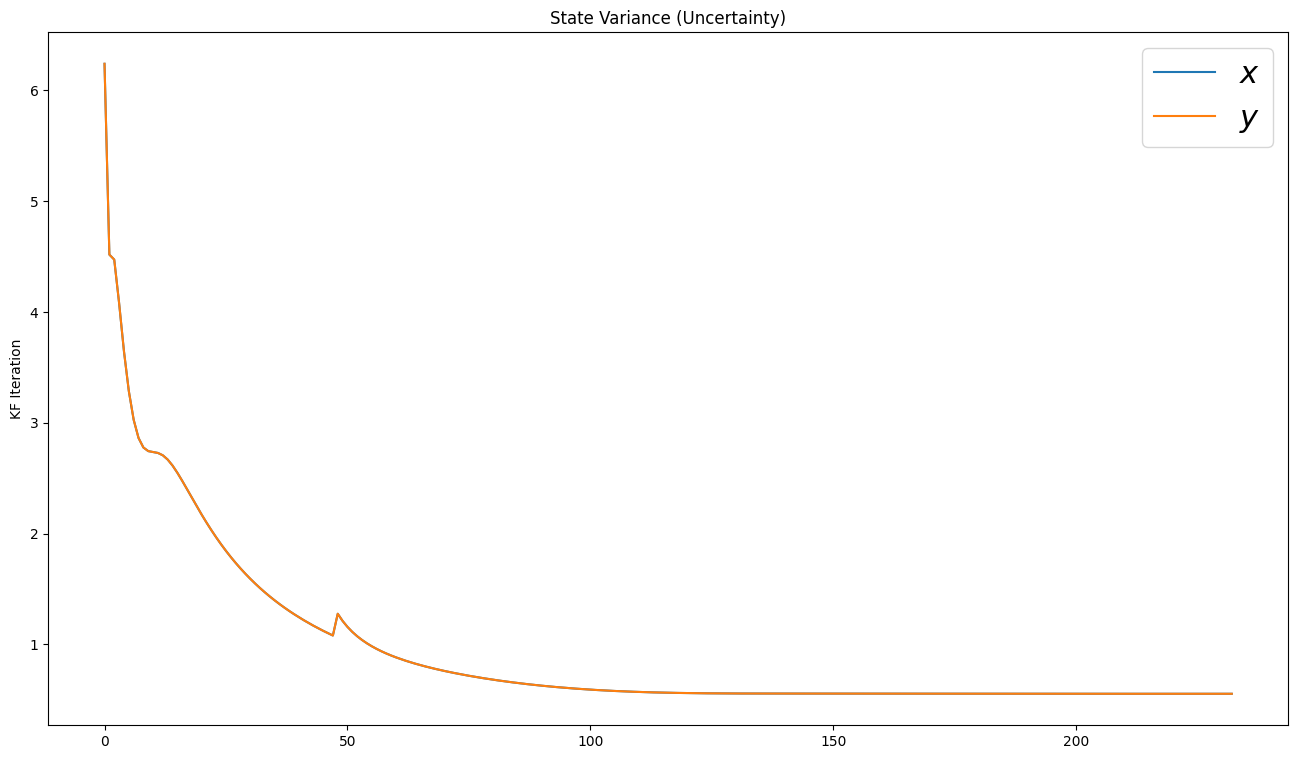

In [6]:
#Uncertainty Plot
fig = plt.figure(figsize=(16,9))

iterations = P.shape[0]

#Pos Uncertainty
plt.plot(range(iterations),px, label='$x$')
plt.plot(range(iterations),py, label='$y$')
# #Vel Uncertainty
# plt.plot(range(iterations),pxv, label='$\dot x$')
# plt.plot(range(iterations),pyv, label='$\dot y$')
# #Acc Uncertainty
# plt.plot(range(iterations),pxa, label='$\ddot x$')
# plt.plot(range(iterations),pya, label='$\ddot y$')

plt.xlabel('')
plt.ylabel('KF Iteration')
plt.title('State Variance (Uncertainty)')
plt.legend(loc='best',prop={'size':22})

plt.show()

### Kalman Gain

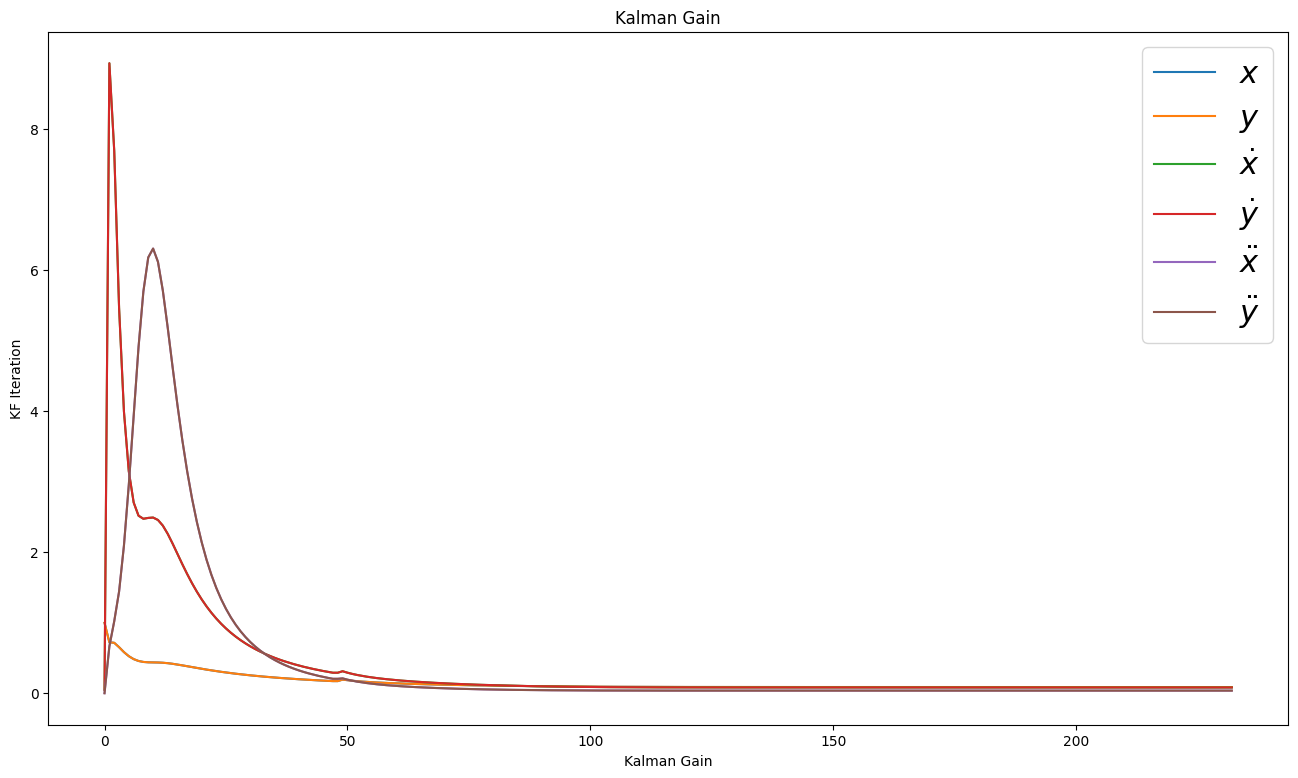

In [7]:
#Kalman Gain Plot
fig = plt.figure(figsize=(16,9))

iterations = P.shape[0]

#Pos KG
plt.plot(range(iterations),kx, label='$x$')
plt.plot(range(iterations),ky, label='$y$')
# #Vel KG
plt.plot(range(iterations),kxv, label='$\dot x$')
plt.plot(range(iterations),kyv, label='$\dot y$')
#Acc KG
plt.plot(range(iterations),kxa, label='$\ddot x$')
plt.plot(range(iterations),kya, label='$\ddot y$')

plt.xlabel('Kalman Gain')
plt.ylabel('KF Iteration')
plt.title('Kalman Gain')
plt.legend(loc='best',prop={'size':22})

plt.show()

## 3D/2D Position Plots

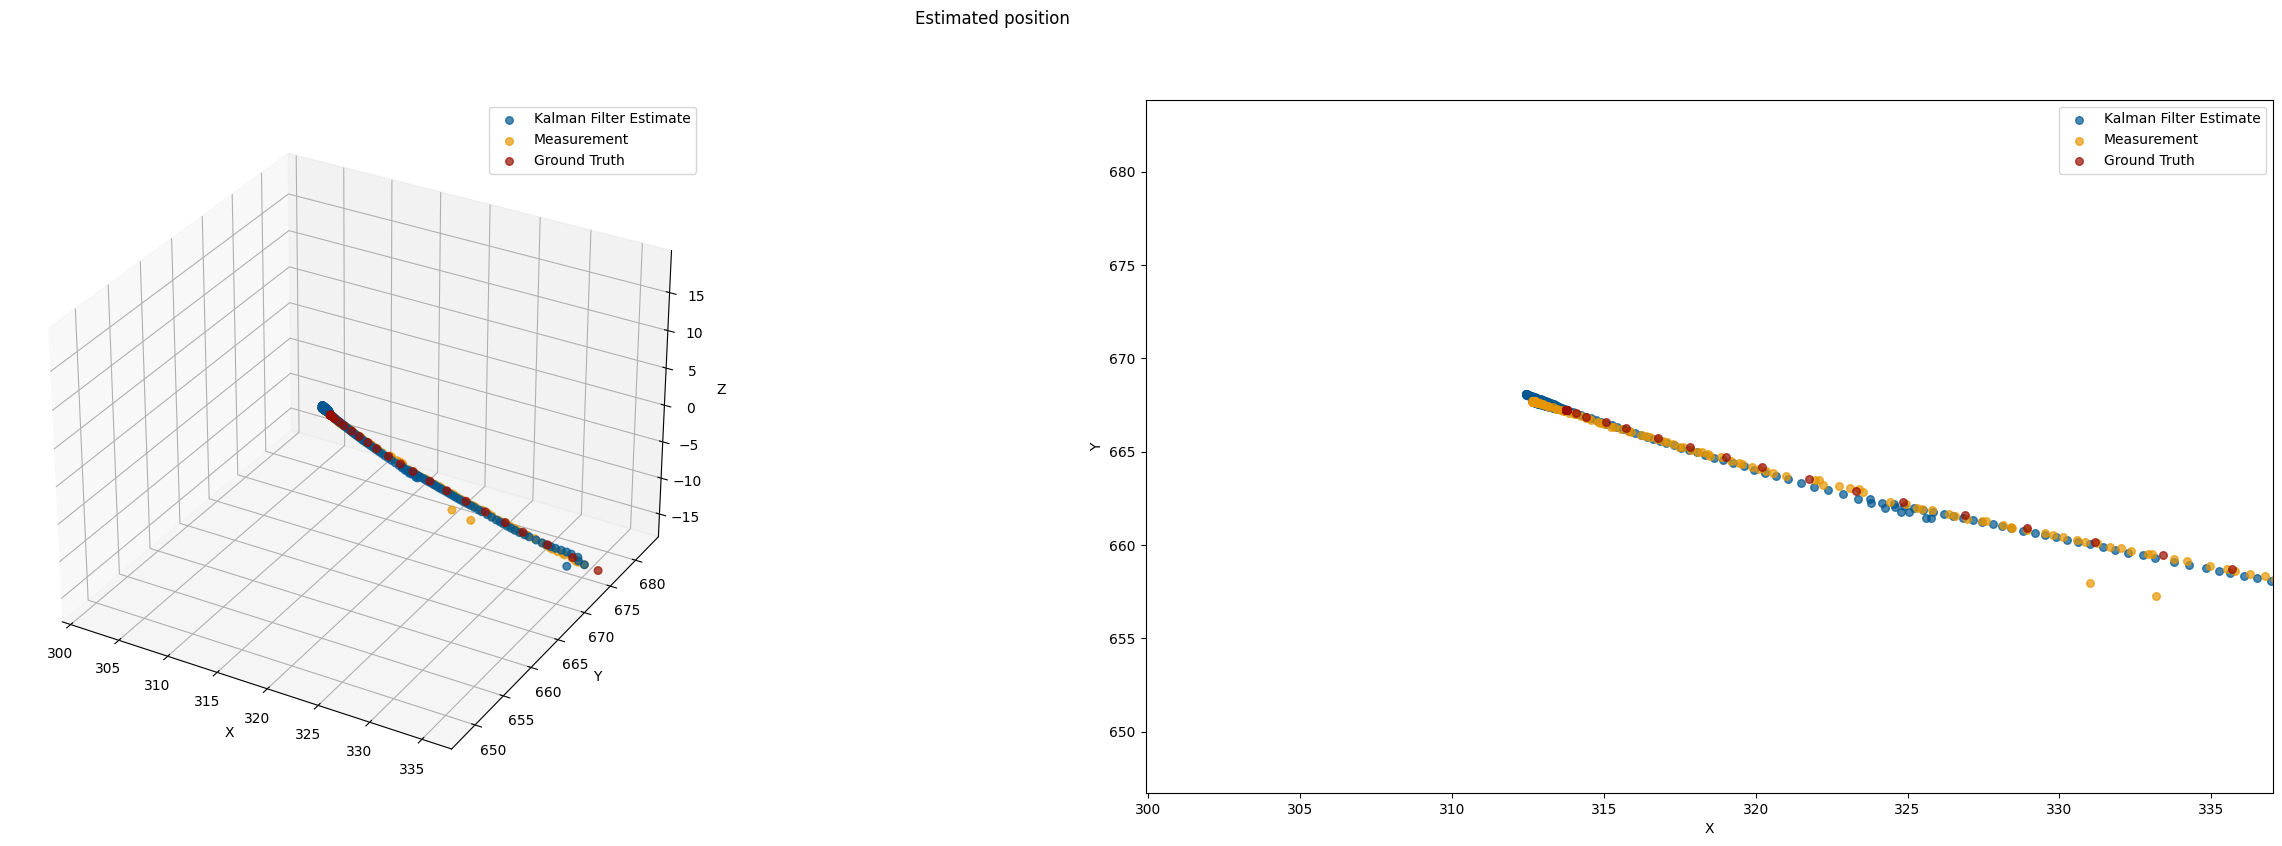

In [8]:
%matplotlib inline
plot(pos_p=pos_p, pos_m=pos_m, pos_a=pos_a)

/home/arian/Documents/SensorFusionTest/AutonomousDrivingTest/utils_obj_det.py:762: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


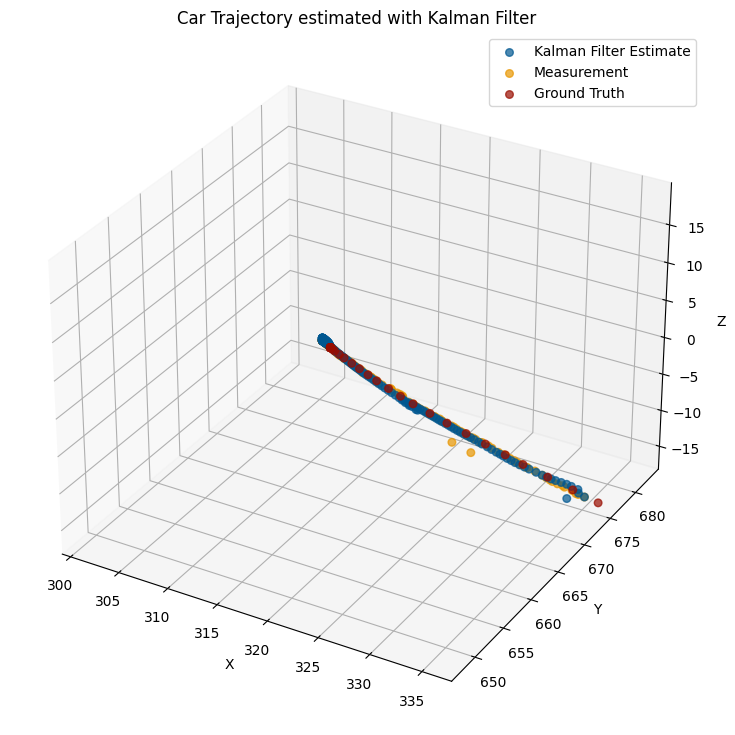

In [9]:
plot_3d(pos_m=pos_m, pos_p=pos_p, pos_a=pos_a)

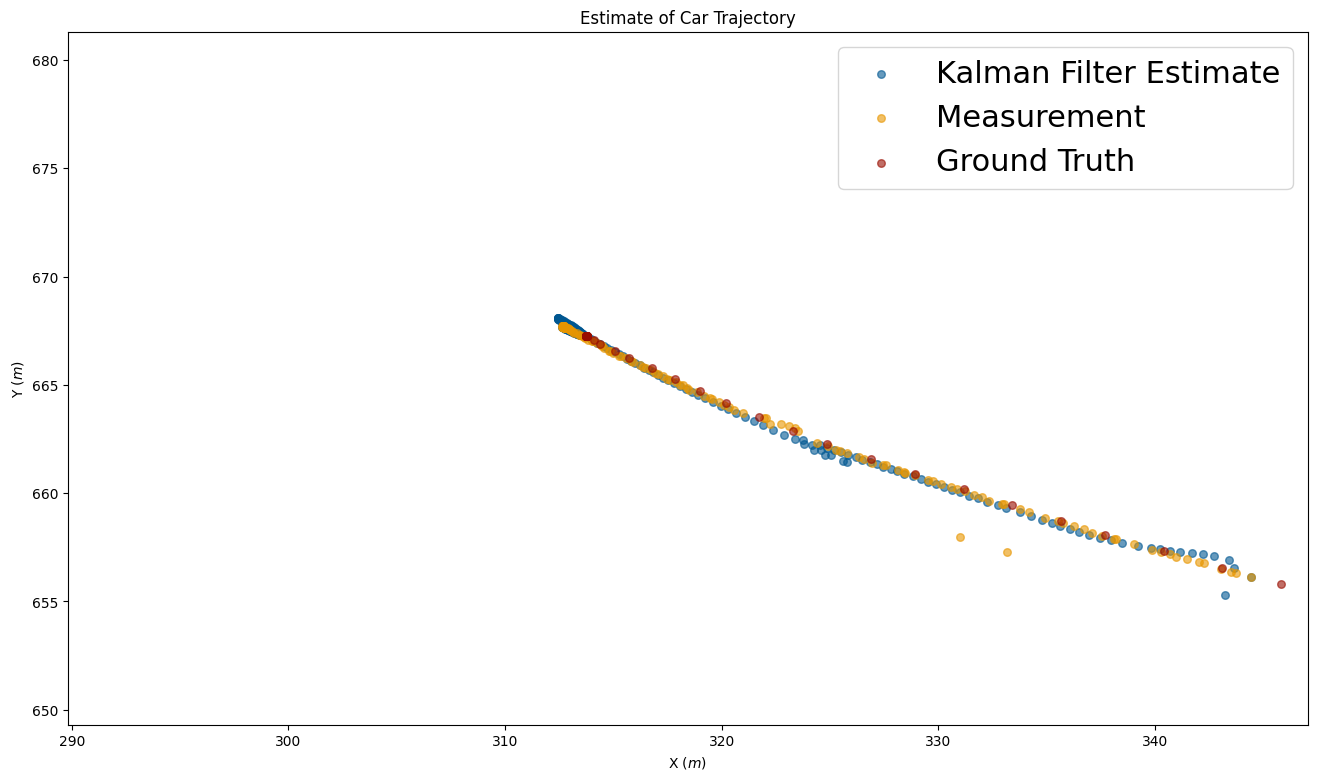

In [10]:
plot_2d(pos_m=pos_m, pos_p=pos_p, pos_a=pos_a)

## 3D Plot against Time

Text(0.5, 0.92, 'Car Trajectory estimated with Kalman Filter')

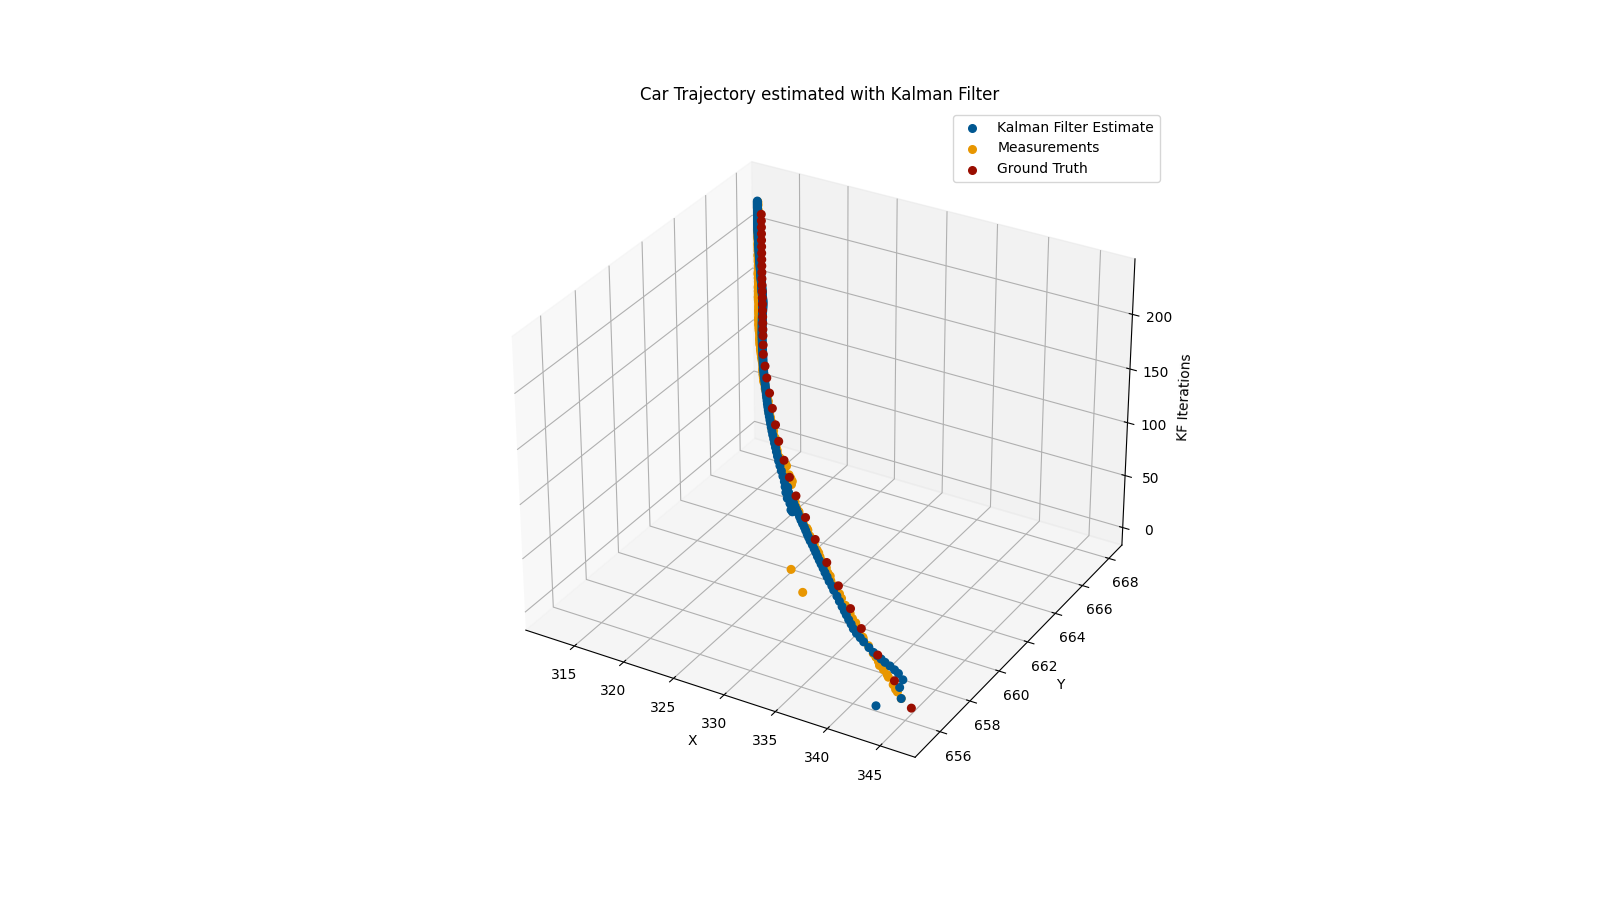

In [12]:
import ipympl
%matplotlib widget
#3D Plot
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111, projection='3d')
#ax.plot(x_p,y_p,z_p, label='Kalman Filter Estimate')

mea_color = [0.91, 0.59, 0]
ann_color = [0.6, 0.05, 0]#[0.72, 0.08, 0.5]
kf_color  = [0, 0.34, 0.57]

ax.scatter(x_p,y_p,range(x_p.shape[0]), label='Kalman Filter Estimate', alpha=1.0, color=kf_color, s=30)
ax.scatter(x_m,y_m,range(x_m.shape[0]), label='Measurements', alpha=1.0, color=mea_color, s=30)
ax.scatter(x_a,y_a,range(x_a.shape[0]), label='Ground Truth', color=ann_color, alpha=1.0, s=30)
#ax.plot(Xr, Yr, Zr, label='Real')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('KF Iterations')
ax.legend()
plt.title('Car Trajectory estimated with Kalman Filter')

# Axis equal
# max_range = np.array([x_p.max()-x_p.min(), y_p.max()-y_p.min(), z_p.max()-z_p.min()]).max() /2
# mean_x = x_p.mean()
# mean_y = y_p.mean()
# mean_z = z_p.mean()
# ax.set_xlim(mean_x - max_range, mean_x + max_range)
# ax.set_ylim(mean_y - max_range, mean_y + max_range)
# ax.set_zlim(mean_z - max_range, mean_z + max_range)
#fig.show()

## L2 Error between prediction-annotations and measurement annotations

Text(0, 0.5, 'Error (m)')

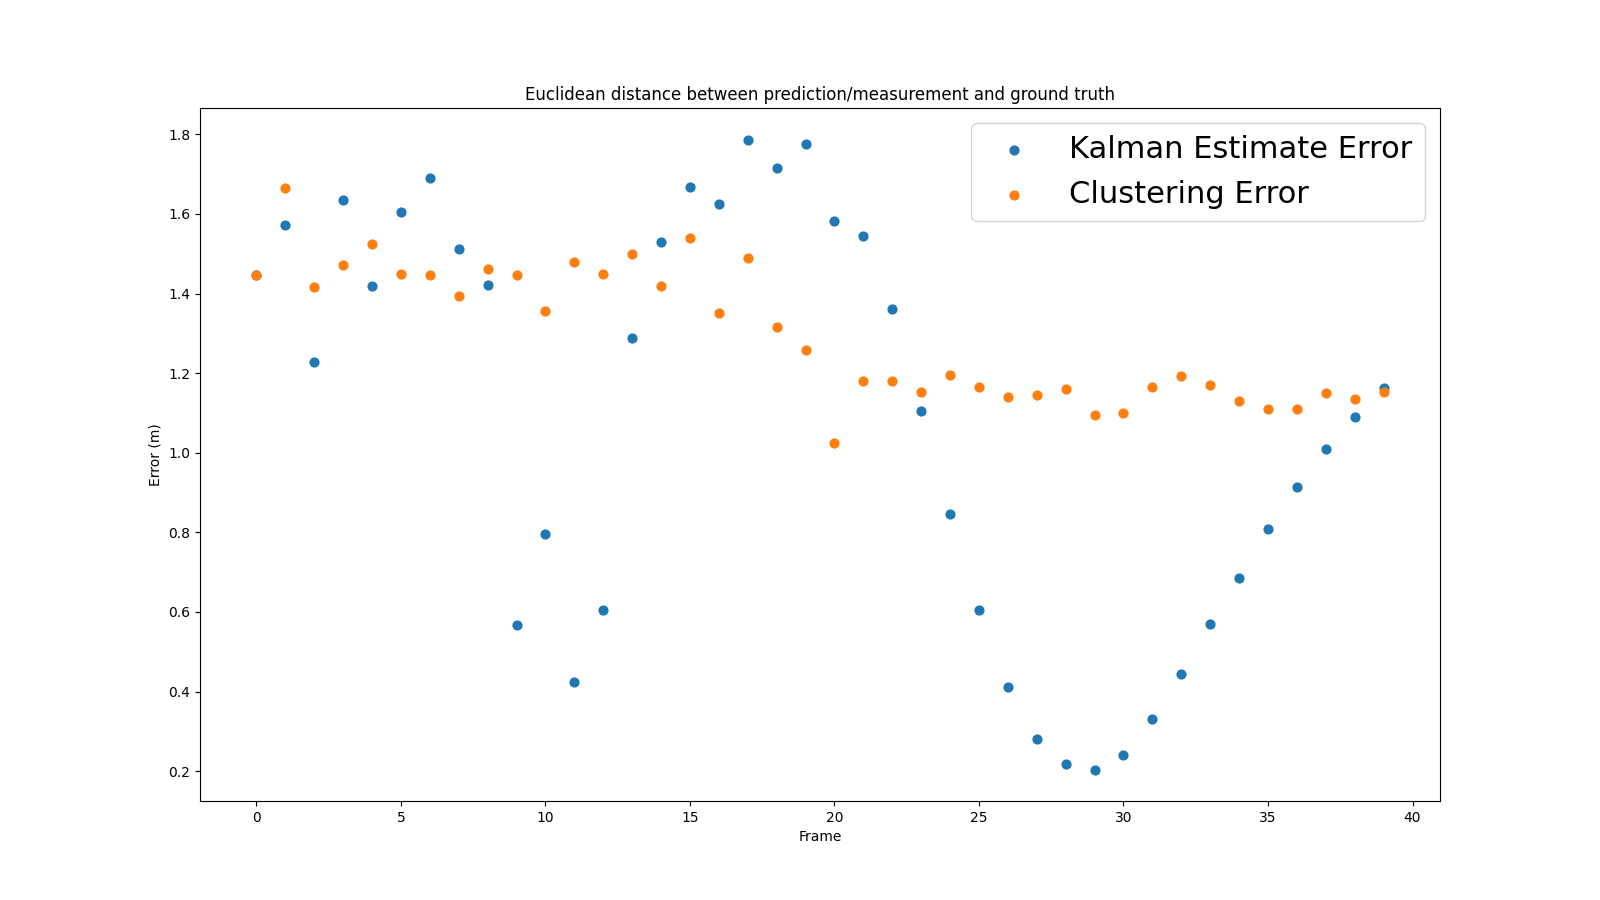

In [13]:
#Error Plot
fig = plt.figure(figsize=(16,9))

error_pa = np.asarray([np.linalg.norm(pos.center_3d[:2] - pos.ann_center[:2]) for pos in detections[idx].prev_poses if not np.isnan(pos.center_3d).any() and not np.isnan(pos.ann_center).any()])
error_ma = np.asarray([np.linalg.norm(pos.cluster_center[:2] - pos.ann_center[:2]) for pos in detections[idx].prev_poses if not np.isnan(pos.cluster_center).any() and not np.isnan(pos.ann_center).any()])

# error_pa = np.linalg.norm(pos_p[:, :2] - pos_a[:, :2], axis=1)
# error_ma = np.linalg.norm(pos_m[:, :2] - pos_a[:, :2], axis=1)


plt.scatter(range(error_pa.shape[0]), error_pa, label='Kalman Estimate Error', s=40, alpha=1)
plt.scatter(range(error_ma.shape[0]), error_ma, label='Clustering Error', s=40, alpha=1)

plt.title('Euclidean distance between prediction/measurement and ground truth')
plt.legend(loc='best',prop={'size':22})
plt.xlabel('Frame')
plt.ylabel('Error (m)')

In [ ]:
#Show Radar extracted speed for objects in camera view
#vis_obj_det_speed(scene, "CAM_FRONT")
#vis_obj_det_speed_sweeps(scene, 'CAM_FRONT')

In [ ]:
#cam_vis(scene, cam_channel='CAM_FRONT')
#top_down_bb(scene)
#cluster_sample(sample)
#top_down_bb_sweep(scene, record=True)

In [ ]:
cluster_in_img_sweep(scene, cam_channel='CAM_BACK', show_bounding_box=True, show_cluster_points=True, show_cluster_center=True, record=True)

# Debug
Epsilon test visualization

In [ ]:
def eps_test(sample, record=False):
    pcd = o3d.geometry.PointCloud()
    first = True

    epsilon = 0.05

    #Render callback for non blocking visualization which allows smoother control of view
    #Define the callback here to simplify the transfer of variables samples, and pcd
    def render_callback(vis):
        nonlocal sample, first, epsilon

        min_pts = 6
        #Load next scan
        lidar = nusc.get('sample_data', sample['data']['LIDAR_TOP'])
        lidar_file = nusc.get_sample_data_path(lidar['token'])
        scan = np.fromfile(lidar_file, dtype=np.float32)
        points = scan.reshape(-1, 5) #x, y, z, intensity, Ring Index

         #Clustering - Get Labels
        labels = np.array(pcd.cluster_dbscan(eps=epsilon, min_points=min_pts))
        if len(labels) > 0:
            #Labels are numbered
            max_label = labels.max()
            print("Number of Clusters: ", max_label+1)
            colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
        else:
            colors = np.full(points.shape, 255)
            

        #Update Geometry
        if first:
            pcd.points = o3d.utility.Vector3dVector(points[:, :3])
            pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])
            vis.add_geometry(pcd)
            first = False
        pcd.points = o3d.utility.Vector3dVector(points[:, :3]) #Only need XYZ
        pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])

        # Update the visualization window and process events to handle keyboard inputs.
        vis.update_geometry(pcd)
        vis.poll_events()
        vis.update_renderer()
        print("Eps: ", epsilon)
        epsilon += 0.05
        return True

    
    # Create an Open3D visualization window.
    vis = o3d.visualization.VisualizerWithKeyCallback()

    # Set the custom update function.
    vis.register_animation_callback(render_callback)
    

    # Start animation.
    vis.create_window()

    opt = vis.get_render_option()
    opt.background_color = np.asarray([0, 0, 0])
    opt.point_size = 2.5 #Original 5

    vis.run()
    vis.destroy_window()

In [ ]:
eps_test(sample)